In [1]:
import numpy as np
import os 
from natsort import natsorted
import h5py
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import re
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from scipy.stats import sem,zscore
import seaborn as sns
from scipy.signal import find_peaks
import mne 
from mne.viz import plot_alignment, snapshot_brain_montage
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib_venn import venn2,venn2_circles,venn3, venn3_circles

In [2]:
acoutipe = "SpectralFlux"  # 'Envelope'  'SpectralFlux' 'SpectralCentroid' "mfcc" 
datatipe = "broadband" #  "HFa"

In [3]:
path = "data\\coherence\\"+ datatipe + "\\" + acoutipe + "\\real\\"

In [4]:
patient_id = ['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10', 'p11']

In [5]:
full_x =[]
full_y =[]
full_z =[]

full_data = []
full_cond = []
full_normatives_names =[]
full_plot_names = []
full_common_names = []
full_caths =[]
full_anods =[]
suj_ids = []

for patient in patient_id:
    spectral_flux = h5py.File(path + patient+ ".h5" ,"r")
    spectral_flux_data = np.asarray(spectral_flux[patient])
    freqs = np.asarray(spectral_flux[patient].attrs['freqs'])
    plot_names = np.asarray(spectral_flux[patient].attrs['ch_names'])
    
    syllabic = np.asarray(spectral_flux[patient].attrs['syll_id'])
    phon = np.asarray(spectral_flux[patient].attrs['phon_id'])
    spectral_flux.close()
    p_info = pd.read_csv("C:\\Users\\Jeremy\\Desktop\\github_syll_phon\\data\\anatomy\\"+ patient +".csv")
    
    # retrieve data only from electrodes that are within the brain and without artefacts
    common_names = []
    for i in plot_names:
        al = i.split('bi')[1]
        lts = re.findall(r'\D+', al)[0]
        nbo,nbt = re.findall(r'\d+', al)
        nee = lts+'_'+nbo+'_'+nbt
        common_names.append(nee)
        
    common_names = np.asarray(common_names)
    caths = []
    anods = []
    posxyz = []
    gind = []
    for num,i in enumerate(common_names):
        if i in p_info['ch_names'].values:
            posxyz.append(p_info.loc[p_info['ch_names'] == i][['x','y','z']].values)
            caths.append(p_info.loc[p_info['ch_names'] == i]['cathodes'].values[0])
            anods.append(p_info.loc[p_info['ch_names'] == i]['anodes'].values[0])
            gind.append(num)
    
    posxyz = np.asarray(posxyz)[:,0,:]
    
    xs = np.asarray(np.repeat(posxyz[:,0],9))
    ys = np.asarray(np.repeat(posxyz[:,1],9))
    zs = np.asarray(np.repeat(posxyz[:,2],9))
    # create electrodes names in a patient specific manner so that we can latter plot in brain space
    normatives = np.repeat([patient+'_'+ ch for ch in common_names[gind]],9)
    restricted = spectral_flux_data[np.asarray(gind)]
    alplot_names = np.repeat(plot_names[np.asarray(gind)],9)
    final_commons = np.repeat(common_names[np.asarray(gind)],9)
    # create conditions specific label so that we can latter average more easily
    conds = np.tile(['3l','3m','3h','6l','6m','6h','9l','9m','9h'],len(gind))
    full_data.append(restricted.reshape(restricted.shape[0]*restricted.shape[1],239))
    full_cond.append(conds)
    full_common_names.append(final_commons)
    full_plot_names.append(alplot_names)
    full_normatives_names.append(normatives)
    suj_ids.append([patient]*len(alplot_names))
    full_x.append(xs)
    full_y.append(ys)
    full_z.append(zs)
    full_caths.append(np.repeat(caths,9))
    full_anods.append(np.repeat(anods,9))

In [6]:
# create big dataframe with info from all patients
moby = {    
    'patient_id':            np.concatenate(suj_ids),
    'common_name':      np.concatenate(full_common_names),
   'plot_name':         np.concatenate(full_plot_names),
    'normative_name':   np.concatenate(full_normatives_names),
    'x' :                 np.concatenate(full_x),
    'y' :                 np.concatenate(full_y),
    'z' :                 np.concatenate(full_z),
    'cathod' :           np.concatenate(full_caths),
    'anod' :              np.concatenate(full_anods),
    'conditions':         np.concatenate(full_cond)}

info = pd.DataFrame.from_dict(moby)
#info = pd.read_csv("C:\\Users\\Jeremy\\Desktop\\github_syll_phon\\data\\anatomy\\localisations_info.csv")

In [7]:
full_data = np.concatenate(full_data)

# Create Panel A

In [8]:
# subselect only one condition for plotting the electrodes
info2 = info.iloc[np.where(info["conditions"].values =='3l')[0]]

In [9]:
coloors = np.array(['gray']*len(info2),dtype='object')
valoors = np.ones(len(info2),dtype = float)
nbers = [29,24,37,54,18,39,22,51,26,15,32]
colrs = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#316395', '#BCBD22', '#17BECF','#00CC96']
colrs = ["#9e0142","#66c2a5","#d53e4f","#fee08b","#e6f598","#abdda4","#f46d43","#3288bd","#fdae61","#5e4fa2","#b49ad9"]
coco = []
for num,nb in enumerate(nbers):
    coco.append([colrs[num]]*nb) 
coco = np.concatenate(coco)
info2 = info2.reset_index(drop=True)

In [10]:
# retrieve speech responsive contacts 
speech_responsive = pd.read_csv("data\\anatomy\\speech_responsive.csv")
speech_responsive = speech_responsive['selected'].values

In [11]:
# put higher values to speech responsive electrodes and add colors for plotting
for num,i in enumerate(speech_responsive):
    coloors[info2.loc[info2['normative_name']==i].index[0]] = coco[num]
    valoors[info2.loc[info2['normative_name']==i].index[0]] = 10

In [12]:
# create legend elements manually
legend_elements = [
    Line2D([0], [0], marker='o',markeredgecolor='k', markerfacecolor="#9e0142",linestyle='', label='Patient 1',markeredgewidth=3, markersize=30),
    Line2D([0], [0], marker='o',markeredgecolor='k', markerfacecolor='#66c2a3',linestyle='', label='Patient 2', markeredgewidth=3,markersize=30),
    Line2D([0], [0], marker='o',markeredgecolor='k', markerfacecolor='#d33e4f', linestyle='',label='Patient 3',markeredgewidth=3, markersize=30),
    Line2D([0], [0], marker='o',markeredgecolor='k', markerfacecolor='#fee03b',linestyle='', label='Patient 4',markeredgewidth=3, markersize=30),
    Line2D([0], [0], marker='o',markeredgecolor='k', markerfacecolor='#e6f393',linestyle='', label='Patient 3',markeredgewidth=3, markersize=30),
    Line2D([0], [0], marker='o',markeredgecolor='k', markerfacecolor='#abdda4',linestyle='', label='Patient 6',markeredgewidth=3, markersize=30),
    Line2D([0], [0], marker='o',markeredgecolor='k', markerfacecolor='#f46d43',linestyle='', label='Patient 7',markeredgewidth=3, markersize=30),
    Line2D([0], [0], marker='o',markeredgecolor='k', markerfacecolor='#3233bd', linestyle='',label='Patient 8', markeredgewidth=3,markersize=30),
    Line2D([0], [0], marker='o',markeredgecolor='k', markerfacecolor='#fdae61',linestyle='', label='Patient 9', markeredgewidth=3,markersize=30),
    Line2D([0], [0], marker='o',markeredgecolor='k', markerfacecolor='#3e4fa2',linestyle='', label='Patient 10',markeredgewidth=3, markersize=30),
    Line2D([0], [0], marker='o',markeredgecolor='k', markerfacecolor='#b49ad9', linestyle='',label='Patient 11',markeredgewidth=3, markersize=30),
    Line2D([0], [0], marker='o',markeredgecolor='k', markerfacecolor='white', linestyle='', label='Non Speech responsive',markeredgewidth=3, markersize=20)
]

In [13]:
# format properly data
final_tobrain = pd.DataFrame(np.asarray([info2["normative_name"].values,info2['x'].values, info2['y'].values, info2['z'].values
                            ,valoors]).T,columns=['normative_name','x','y','z','first_pk_amp'])


Using notebook 3d backend.

Channel types::	seeg: 1860


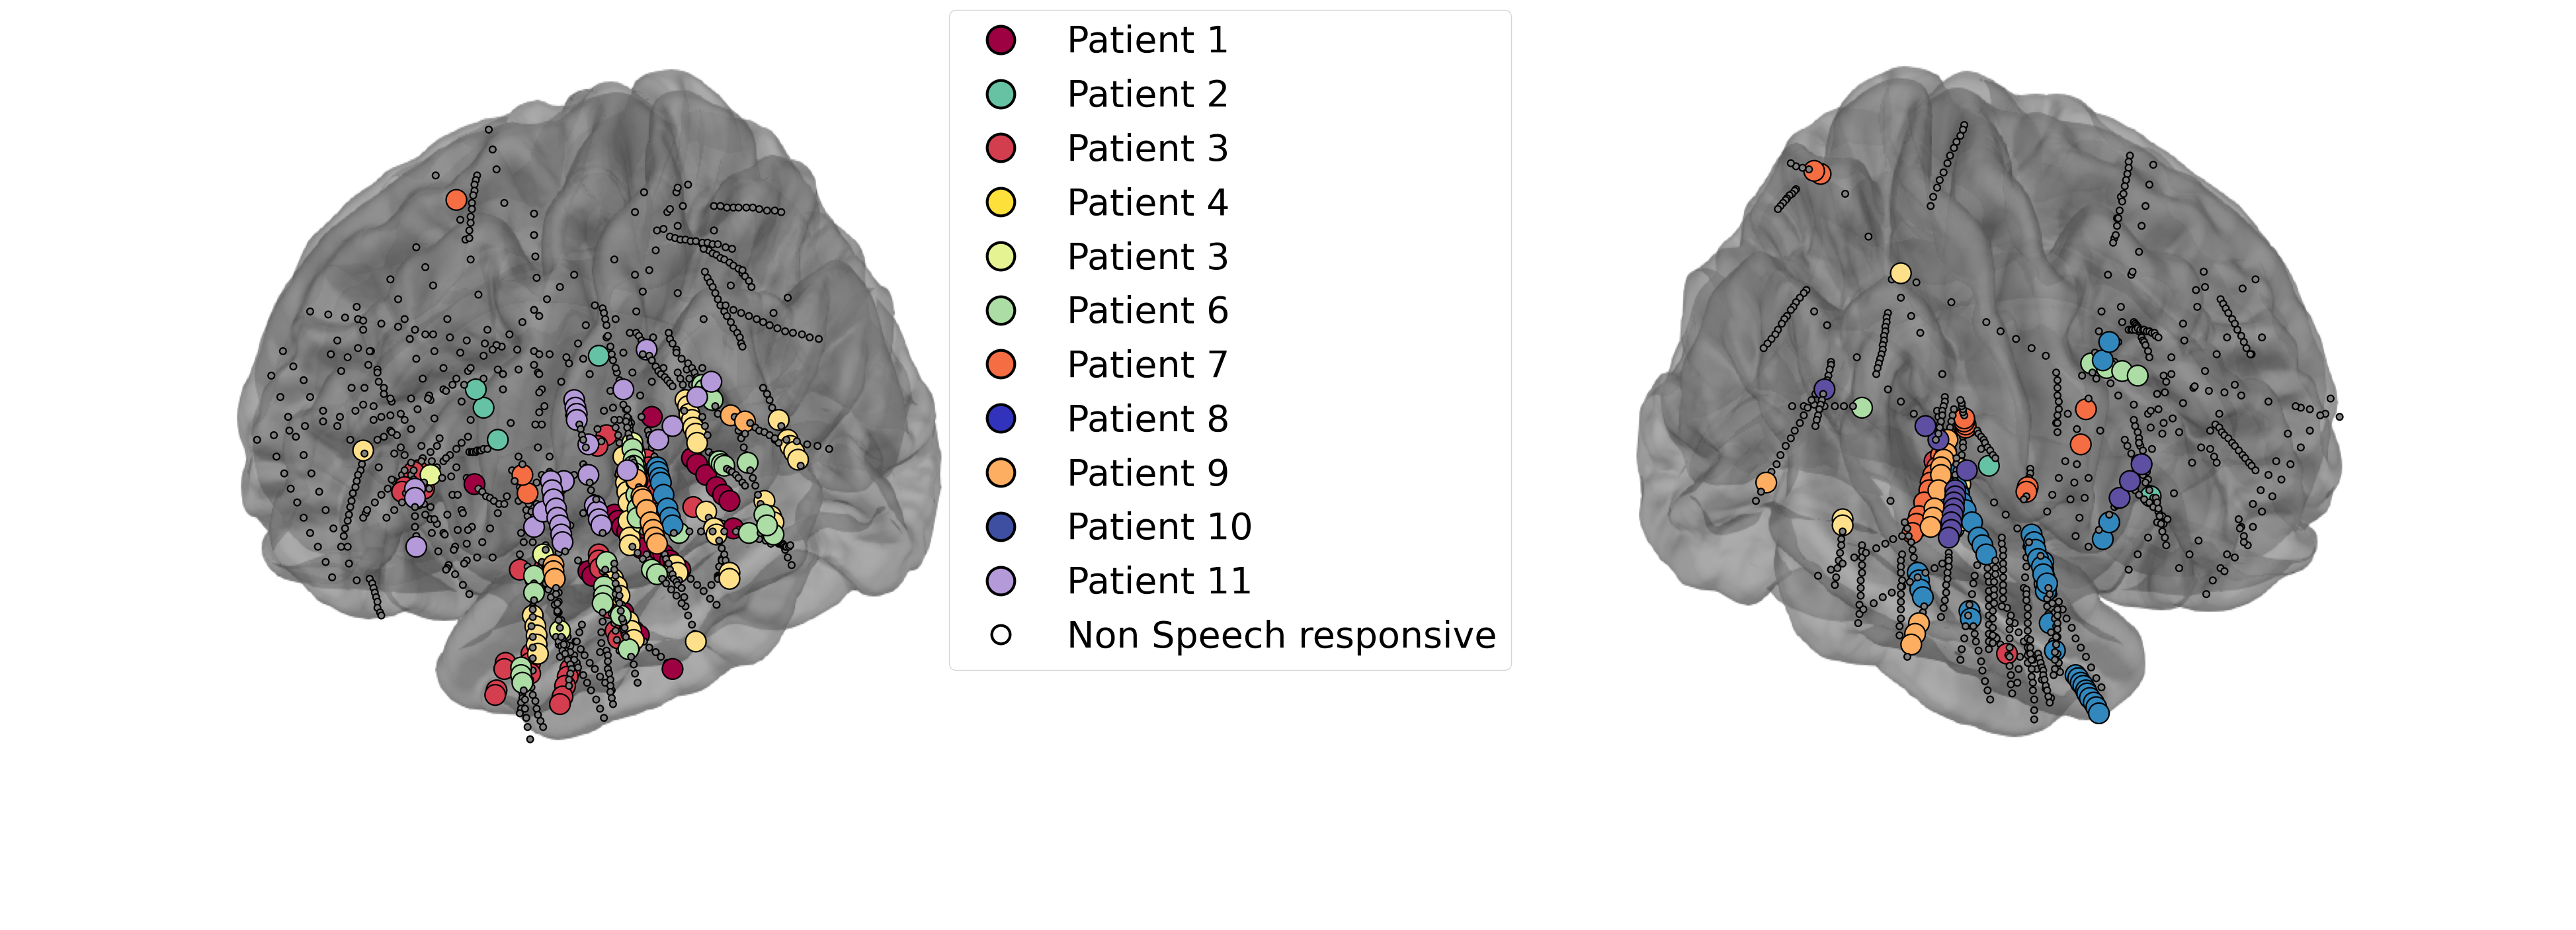

In [14]:
for i in ('x','y','z','first_pk_amp'):
    final_tobrain[i] = final_tobrain[i].astype(float)
datas_to_plot = [final_tobrain["first_pk_amp"].values]
ch_names = final_tobrain['normative_name'].values
loc = final_tobrain[['x','y','z']].values
# Declare montage
ch_pos = dict(zip(ch_names, loc))
montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame='head')
info_ = mne.create_info(list(ch_names), 1000., ch_types='seeg').set_montage(montage)


mne.viz.set_3d_backend("notebook")
fig = mne.viz.create_3d_figure(size=(900, 600), bgcolor='white', scene=True)
subjects_dir = "data\\anatomy\\anatomy2\\"
trans =  mne.read_trans(subjects_dir + '\\fsaverage\\fsaverage-trans.fif')
surfaces = {'brain': 0.1}

fig =plot_alignment(info=info_,trans=trans,subject='fsaverage',subjects_dir=subjects_dir,
                 surfaces=surfaces,seeg=True, interaction='terrain',coord_frame='mri',fig=fig)

mne.viz.set_3d_view(fig,azimuth=-180, elevation=-70,distance = 0.37)
xy, im = snapshot_brain_montage(fig, montage)
xy_pts1 = np.vstack([xy[ch] for ch in info_['ch_names']])

mne.viz.set_3d_view(fig,azimuth=180, elevation=70,distance = 0.37)
xy,im2 = snapshot_brain_montage(fig, montage)
xy_pts2 = np.vstack([xy[ch] for ch in info_['ch_names']])


images = [im2,im]
idxs = [0,0]
vmins = [0.01,0.01,0.0,0.0]
vmaxs = [0.1,0.1,0.06,0.06]
mins = [0.025, 0.025,0.015, 0.015]

 
fig2, axs = plt.subplots(1,2,figsize=(50, 18))
t = []

for i,(ax,image,idx,vmin,vmax,mino) in enumerate(zip(axs.ravel(),images,idxs,vmins,vmaxs,mins)):

    if (i % 2) == 0:
        ax.imshow(image, aspect='auto') 
        mask = loc[:, 0] < 0 # Data for electrodes in left hemisphere are set to np.nan
        sizes = datas_to_plot[idx][mask]
        sizes=sizes*50
        m = ax.scatter(*xy_pts2[mask].T, color=coloors[mask], s=sizes, linewidths=1.6, edgecolors='k', alpha=1) 
        t.append(m)
    else:
        ax.imshow(image, aspect='auto')
        mask = loc[:, 0] >0 # Data for electrodes in left hemisphere are set to np.nan
        sizes = datas_to_plot[idx][mask] 
        sizes=sizes*50

        m = ax.scatter(*xy_pts1[mask].T, color=coloors[mask], s = sizes,linewidths=1.6, edgecolors='k', alpha=1) 
    ax.set_axis_off()

# Plot colorbar

cax1 = fig2.add_axes([0.41, 0.5, 0.17, 0.2])
cax1.set_axis_off()
cax1.legend(handles=legend_elements, loc='center',fontsize="40")

plt.subplots_adjust(hspace=0)
#fig2.savefig( "fig3A.png",  dpi=300, format=None,facecolor='white', edgecolor='white' , bbox_inches='tight')

# Create Panel B

In [15]:
# subselect data and info based on the speech responsiveness of electrodes
full_data  = full_data[info.loc[info['normative_name'].isin(speech_responsive)].index.values]
info  = info.iloc[info.loc[info['normative_name'].isin(speech_responsive)].index.values]
info = info.reset_index(drop=True)

In [16]:
# create indexes to regroup data according to specific conditions
good_conds =[np.where(info["conditions"].values =='3l')[0],np.where(info["conditions"].values =='3m')[0],
              np.where(info["conditions"].values =='3h')[0],np.where(info["conditions"].values =='6l')[0],
              np.where(info["conditions"].values =='6m')[0],np.where(info["conditions"].values =='6h')[0],
              np.where(info["conditions"].values =='9l')[0],np.where(info["conditions"].values =='9m')[0],
              np.where(info["conditions"].values =='9h')[0]]

names_conds = ['3HZ low', '3Hz medium', '3Hz high',
               '6Hz low', '6Hz medium', '6Hz high',
               '9Hz low', '9Hz medium', '9Hz high']

colors = ['paleturquoise',"dodgerblue","navy","mistyrose","lightcoral","darkred","yellowgreen","green","darkslategray"]


In [17]:
pa1 = mlines.Line2D([0], [0], color=colors[0], lw=4)
pa2 = mlines.Line2D([0], [0], color=colors[1], lw=4)
pa3 = mlines.Line2D([0], [0], color=colors[2], lw=4)

pb1 = mlines.Line2D([0], [0], color=colors[3], lw=4)
pb2 =mlines.Line2D([0], [0], color=colors[4], lw=4)
pb3 = mlines.Line2D([0], [0], color=colors[5], lw=4)

pc1 =mlines.Line2D([0], [0], color=colors[6], lw=4)
pc2 = mlines.Line2D([0], [0], color=colors[7], lw=4)
pc3 =mlines.Line2D([0], [0], color=colors[8], lw=4)

pp = mlines.Line2D([], [], marker='^', linestyle='None',mec='k', mfc='grey', mew=1,
                          markersize=10,label='Syllabic timescale')
                

In [18]:
stats_path = "C:\\Users\\Jeremy\\Desktop\\github_syll_phon\\data\\coherence\\"+datatipe+"\\stats\\"

In [19]:
stats = np.load( stats_path + acoutipe + '_stats.npy' , allow_pickle=True)
stats = np.asarray(stats).reshape((3,3))

In [20]:
custom_lines = [mlines.Line2D([0], [0], color=colors[0], lw=4),
                mlines.Line2D([0], [0], color=colors[1], lw=4),
                mlines.Line2D([0], [0], color=colors[2], lw=4),
               mlines.Line2D([], [], marker='^', linestyle='None',mec='k', mfc='grey', mew=1,
                          markersize=22,label='Syllabic timescale')]

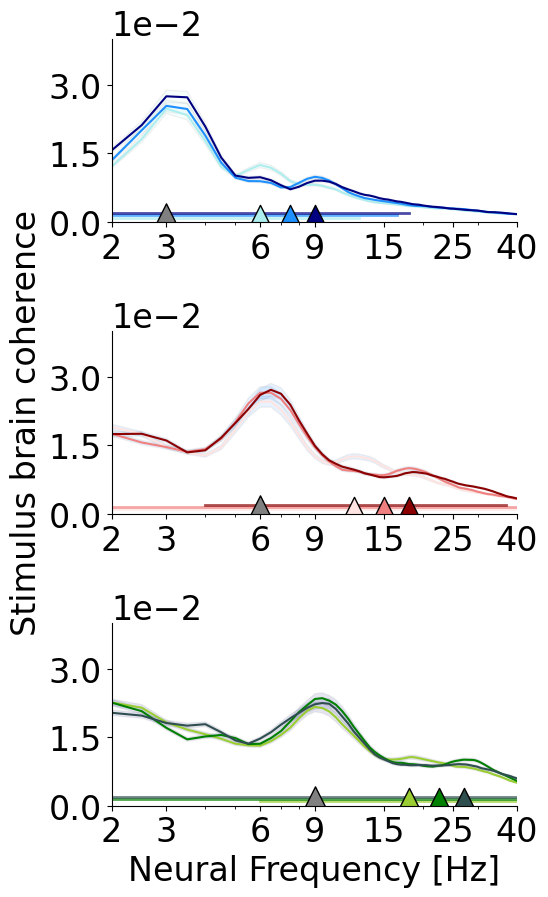

In [21]:
# Plot mean CaCoh across ALL subjects & ALL electrodes for each condition

name_cond = ['low', 'medium', 'high','low', 'medium', 'high', 'low', 'medium', 'high']
matplotlib.rcParams.update({'font.size': 24})

fig,axs = plt.subplots(3,1, figsize=(6,9.5))

idxx = [[0,1,2],[3,4,5],[6,7,8]]
alphas = [1,0.7,0.4]
condi = [3,6,9]
ys = [0.001, 0.0015, 0.002]
legs = [[pa1,pa2,pa3,pp],[pb1,pb2,pb3,pp],[pc1,pc2,pc3,pp]]

colors = ['paleturquoise',"dodgerblue","navy","mistyrose","lightcoral","darkred","yellowgreen","green","darkslategray"]


for i, (num,ax) in enumerate(zip(range(3),axs.ravel())) :
        for j in range(3):
            aldat = full_data[good_conds[idxx[i][j]]]#*np.sqrt(freqs)
            doto = np.mean(full_data[good_conds[idxx[i][j]]],0)#*np.sqrt(freqs)
            ax.plot(freqs,doto,color= colors[idxx[i][j]],label=name_cond[idxx[i][j]]);
            ax.fill_between(freqs,doto +sem(aldat),doto -sem(aldat),alpha = 0.1, edgecolor = 'grey', facecolor = colors[i] ) 
            ax.plot(stats[i][j],np.repeat(ys[j],len(stats[i][j])), color = colors[idxx[i][j]], linewidth = 2,zorder=0, alpha = 0.7 )
        if num == 0:
            ax.scatter(6,0.0005, marker='^',s = 475,linewidth=1,edgecolor='black', color='paleturquoise',zorder=1)
            ax.scatter(7.5,0.0005, marker='^',s = 475,linewidth=1,edgecolor='black', color='dodgerblue',zorder=1)
            ax.scatter(9,0.0005, marker='^',s = 475,linewidth=1,edgecolor='black', color='navy',zorder=1)

        
        if num == 1:
            ax.set_ylabel('Stimulus brain coherence',fontsize=24);
            ax.scatter(12,0.0005, marker='^',s = 475,linewidth=1,edgecolor='black', color='mistyrose',zorder=1)
            ax.scatter(15,0.0005, marker='^',s = 475,linewidth=1,edgecolor='black', color='lightcoral',zorder=1)
            ax.scatter(18,0.0005, marker='^',s = 475,linewidth=1,edgecolor='black', color='darkred',zorder=1)
        
        if num == 2:
            ax.scatter(18,0.0005, marker='^',s = 475,linewidth=1,edgecolor='black', color='yellowgreen',zorder=1)
            ax.scatter(22.5,0.0005, marker='^',s = 475,linewidth=1,edgecolor='black', color='green',zorder=1)
            ax.scatter(27,0.0005, marker='^',s = 475,linewidth=1,edgecolor='black', color='darkslategray',zorder=1)


        ax.spines['right'].set_visible(False)
        ax.scatter(condi[i],0.0005, marker='^',s = 575,linewidth=1,edgecolor='black',zorder=1, color='grey')
        ax.spines['top'].set_visible(False)
        ax.set_xlim(2,40)
        ax.set_ylim(0)
        ax.semilogx()   
        ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0)) 
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter());

        ax.set_xticks([2,3,6,9,15,25,40]);
        ax.set_yticks([0.0,0.015,0.03]);
        ax.set_ylim(0,0.04)  #   broadband sf 0.03 env 0.046        HFa sf 0.025  env 0.0195 sc 0.021
ax.set_xlabel("Neural Frequency [Hz]",fontsize=24);
fig.tight_layout()
#fig.savefig( "figure3B",  dpi=300,  format="svg", metadata=None,facecolor=None, edgecolor=None , bbox_inches='tight')

# Create Panel C

In [26]:
accuracy = pd.read_csv("data\\coherence_classification\\broadband\\coherence_SpectralFlux_accuracy.csv") 

In [27]:
def jiters(x):
    np.random.seed(seed=100)
    return x+ np.random.normal(0,0.05,len(x))

In [28]:
std1 = np.std(accuracy['decoding accuracy (%)'][0:10],0)
std2 = np.std(accuracy['decoding accuracy (%)'][10::],0)
dataplot = accuracy.groupby('conditions')['decoding accuracy (%)'].mean().values[::-1]
custom_line = [Line2D([1], [0], color='gold', lw=4, linestyle='--')]

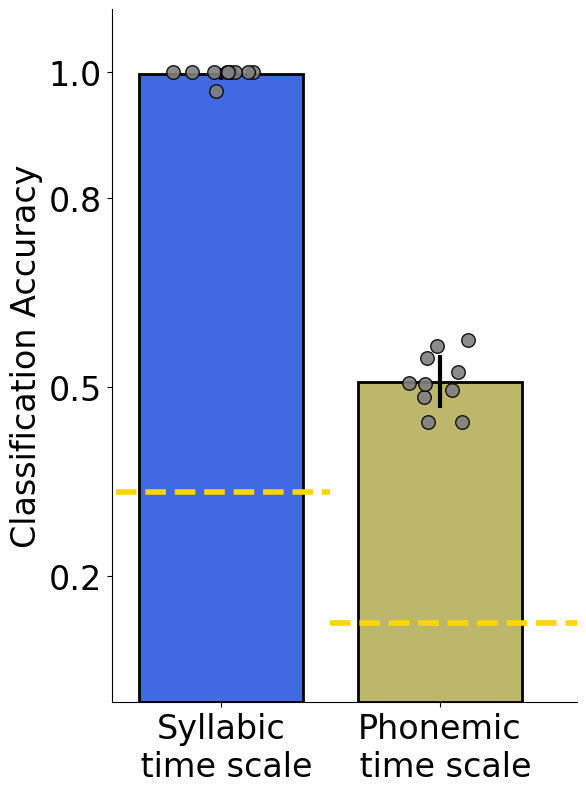

In [29]:
plt.rcParams.update({'font.size': 24})
fig,ax = plt.subplots(1,1,figsize=(6,9))

ax.bar(x=[0.5,0.9], height=dataplot ,yerr =[std1,std2], color= ['royalblue','darkkhaki'],zorder=1, edgecolor='k',linewidth=2,width=0.3,error_kw = {"linewidth":3})
ax.scatter(jiters(np.repeat([0.5,0.9],10)),accuracy['decoding accuracy (%)'].values,s=95,zorder=2, color="grey", edgecolor='k',alpha=0.9)


ax.xaxis.set_label_coords(0.43,-0.19)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0,1.1)
ax.set_xlim(0.3,1.15)
ax.xaxis.set_label_coords(0.54,-0.05)

ax.hlines(1/3,0.2,0.7, linestyle='--', color = 'gold',linewidth=4);
ax.hlines(1/8,0.7,1.15, linestyle='--', color = 'gold',linewidth=4);
ax.set_xticks([0.5,0.9]);ax.set_xticklabels(['Syllabic\n time scale','Phonemic\n time scale'])
ax.set_yticks([0.2,0.5,0.8,1]);
ax.set_ylabel("Classification Accuracy");
#fig.savefig( "figure3C.png",  dpi=300, bbox_inches='tight',  facecolor=None, edgecolor=None )

# Create Panel D

In [30]:
pics =  pd.read_csv("data\\peak_comparison\\slope_brain_SpectralFlux.csv")

In [31]:
firstpeaks = pics.loc[(pics['peaks']=='first')&(pics['conds']=='syll')]['real'].values
secondpeaks = pics.loc[(pics['peaks']=='second')&(pics['conds']=='syll')]['real'].values
pepeaks = np.asarray(list(zip(firstpeaks,secondpeaks))).reshape(11,9,2)

In [32]:
c1,c2,c3,c4,c5,c6,c7,c8,c9 =colors
lab1,lab2,lab3,lab4,lab5,lab6,lab7,lab8,lab9 =names_conds
edgco = 'k'
p1 = mpatches.Patch(facecolor=c1, label=lab1,edgecolor=edgco)
p2 = mpatches.Patch(facecolor=c2, label=lab2,edgecolor=edgco)
p3 = mpatches.Patch(facecolor=c3, label=lab3,edgecolor=edgco)
p4 = mpatches.Patch(facecolor=c4, label=lab4,edgecolor=edgco)
p5 = mpatches.Patch(facecolor=c5, label=lab5,edgecolor=edgco)
p6 = mpatches.Patch(facecolor=c6, label=lab6,edgecolor=edgco)
p7 = mpatches.Patch(facecolor=c7, label=lab7,edgecolor=edgco)
p8 = mpatches.Patch(facecolor=c8, label=lab8,edgecolor=edgco)
p9 = mpatches.Patch(facecolor=c9, label=lab9,edgecolor=edgco)

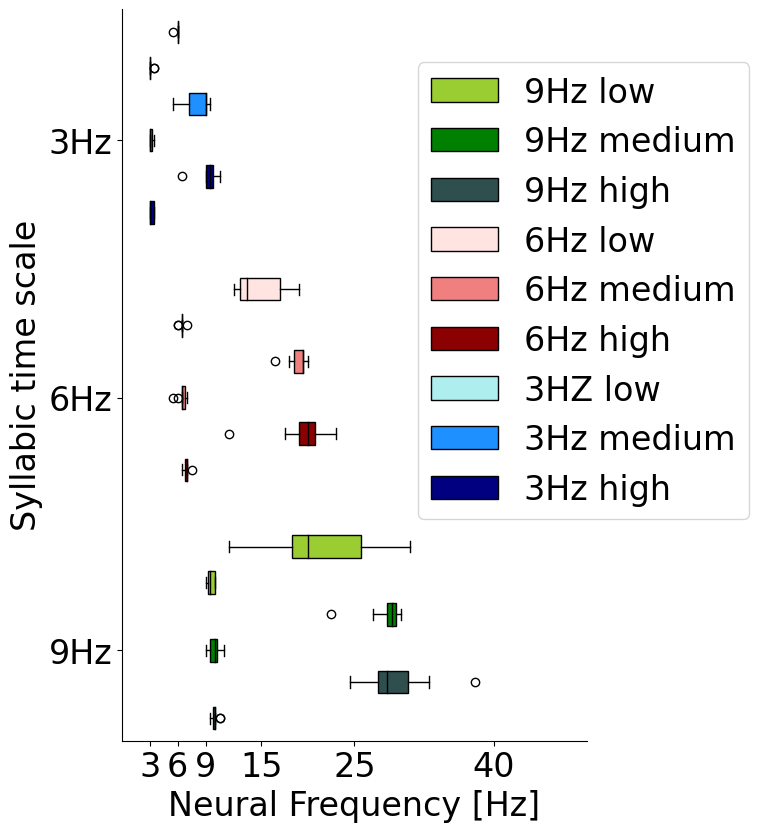

In [33]:
fig,ax = plt.subplots(1,1, figsize = (6,9.5))
matplotlib.rcParams.update({'font.size': 24})
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter());

box1 = ax.boxplot(pepeaks[:,[8,7,6,5,4,3,2,1,0],:].reshape(11,9*2),patch_artist=True,vert=False, positions=[1,1.8, 2.5,3.3, 4,4.8,  6.5,7.3, 8.1,8.9,9.7, 10.5,  12.2,13, 13.8, 14.6, 15.4, 16.2 ])
for patch, color in zip(box1['boxes'], np.repeat(np.asarray(colors)[[8,7,6,5,4,3,2,1,0]],2)):
        patch.set_facecolor(color)
for element in box1['medians']:
        element.set_color('k')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0,50)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter());

ax.set_xticks([3,6,9,15,25,40]);
ax.set_xlabel("Neural Frequency [Hz]",fontsize = 24);
ax.set_yticks([ 2.5, 8.1 , 13.8]);ax.set_yticklabels(['9Hz','6Hz','3Hz'],fontsize = 24);
ax.set_ylabel("Syllabic time scale",fontsize = 24);

ax.legend(bbox_to_anchor=(0.6, 0.95),handles=[p7,p8,p9,p4,p5,p6,p1,p2,p3,],fontsize=24);
#fig.savefig( "figure3D.png",  dpi=300,facecolor=None, edgecolor= None , bbox_inches='tight')

# Create Panel E

In [34]:
# get data and format for figure
firstspp = pics.loc[(pics.peaks=='first')&(pics.conds=='syll')]['pred'].values    
secspp = pics.loc[(pics.peaks=='second')&(pics.conds=='phon')]['pred'].values                                     
fi = pics.loc[(pics.peaks=='first')&(pics.conds=='syll')]['real'].values
se = pics.loc[(pics.peaks=='second')&(pics.conds=='phon')]['real'].values
doot = [fi,se,fi,se]
against = [firstspp,firstspp,secspp,secspp]



# get correlations between predicted peaks and observed peaks
rfirst = np.corrcoef(fi,firstspp)[0][1]
rsecond = np.corrcoef(se,secspp)[0][1]
ffirst = np.corrcoef(fi,secspp)[0][1]
fsecond = np.corrcoef(se,firstspp)[0][1]


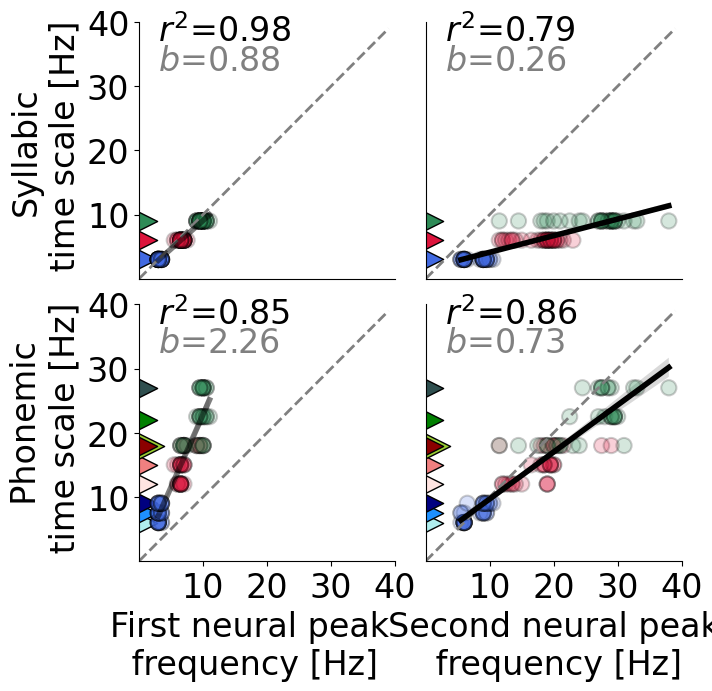

In [35]:
colours = np.repeat(["royalblue","crimson","seagreen"],33)
alphas = [0.5,1,0.5,1]
matplotlib.rcParams.update({'font.size': 24})

xlabs = ["","","First neural peak\n frequency [Hz]","Second neural peak\n frequency [Hz]"]
ylabs = ["Syllabic\n time scale [Hz]","","  Phonemic\n time scale [Hz]",""]

cors = [str(i**2)[0:4] for i in [rfirst ,fsecond,ffirst,rsecond]] #
xs = [3,3,3,3]
ys = [37,37,37,37]

lis = [40,40,40,40]



titles = []
fig,axs = plt.subplots(2,2,figsize=(7,7))
for i, ax in enumerate(axs.flat):
    ax.plot(np.arange(0,lis[i]),np.arange(0,lis[i]),'--',linewidth=2, color = 'gray')

    x = doot[i]
    y = against[i]
    x = x[np.argsort(y)]
    y = y[np.argsort(y)]

    coco = np.corrcoef(x,y)[0][1]

    a, b = np.polyfit(x, y, 1)
    sns.regplot(x = x, y=y,ax = ax,scatter = False,color="k",line_kws={"alpha":alphas[i],"linewidth":4})
    ax.scatter(x,y,color=colours,alpha=0.2,s=120,
              linewidths=1.5,edgecolors='black');#scatter_kws={"color": colors[i]}, line_kws={"color": "k"}) 425
    ax.set_xticks([10,20,30,40])
    ax.set_yticks([10,20,30,40])

    if i in [0,1]:
        ax.scatter(0.4,3, marker='>',s = 475,linewidth=1,edgecolor='black', color='royalblue',zorder=0)
        ax.scatter(0.4,6, marker='>',s = 475,linewidth=1,edgecolor='black', color='crimson',zorder=0)
        ax.scatter(0.4,9, marker='>',s = 475,linewidth=1,edgecolor='black', color='seagreen',zorder=0)
        ax.set_xticks([])
    else:
        ax.scatter(0.4,6, marker='>',s = 475,linewidth=1,edgecolor='black', color='paleturquoise',zorder=0)
        ax.scatter(0.4,7.5, marker='>',s = 475,linewidth=1,edgecolor='black', color='dodgerblue',zorder=0)
        ax.scatter(0.4,9, marker='>',s = 475,linewidth=1,edgecolor='black', color='navy',zorder=0)
        ax.scatter(0.4,12, marker='>',s = 475,linewidth=1,edgecolor='black', color='mistyrose',zorder=0)
        ax.scatter(0.4,15, marker='>',s = 475,linewidth=1,edgecolor='black', color='lightcoral',zorder=0)
        ax.scatter(1.5,18, marker='>',s = 475,linewidth=1,edgecolor='black', color='yellowgreen',zorder=0)
        ax.scatter(0.4,18, marker='>',s = 475,linewidth=1,edgecolor='black', color='darkred',zorder=0)
        ax.scatter(0.4,22, marker='>',s = 475,linewidth=1,edgecolor='black', color='green',zorder=0)
        ax.scatter(0.4,27, marker='>',s = 475,linewidth=1,edgecolor='black', color='darkslategray',zorder=0)
    axs.ravel()[1].set_yticks([])
    axs.ravel()[3].set_yticks([])

    ax.set_xlim(0,lis[i])
    ax.set_ylim(0,lis[i])

    axs.ravel()[2].xaxis.set_label_coords(0.43,-0.19)
    axs.ravel()[3].xaxis.set_label_coords(0.59,-0.19)

    ax.set_xlabel(xlabs[i],fontsize=24)
    ax.set_ylabel(ylabs[i],fontsize=24)
    ax.text(xs[i],ys[i],r'$r^{2}$=' + str(np.round(float(str(coco)[0:4])**2,2)),size=24)#,alpha=alphas[i])cors[i]
    ax.text(xs[i],ys[i]-4.5,r'$b$=' +str(np.round(a,2)), color = "grey",size=24)#,alpha=alphas[i])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.subplots_adjust(hspace=0.1,wspace=0.12)
#fig.savefig( "fig3E.png",  dpi=300, format='svg', metadata=None,facecolor=None, edgecolor=None , bbox_inches='tight')

# Create Panel F

In [123]:
SF = pd.read_csv("data\\RSR\\SF.csv")

In [124]:
# retrieve speech responsive contacts 
speech_responsive = pd.read_csv("data\\anatomy\\speech_responsive.csv")
speech_responsive = speech_responsive['selected'].values

In [125]:
SF= SF.loc[SF['normative_name'].isin(speech_responsive)]

In [126]:
# format properly
final_tobrain = pd.DataFrame(np.asarray([SF['normative_name'].values,SF['x'].values,SF['y'].values,SF['z'].values
                            ,SF['RSR_lowFreq'].values,SF['RSR_highFreq'].values]).T,
                             columns=['normative_name','x','y','z','first','second'])


Channel types::	seeg: 347


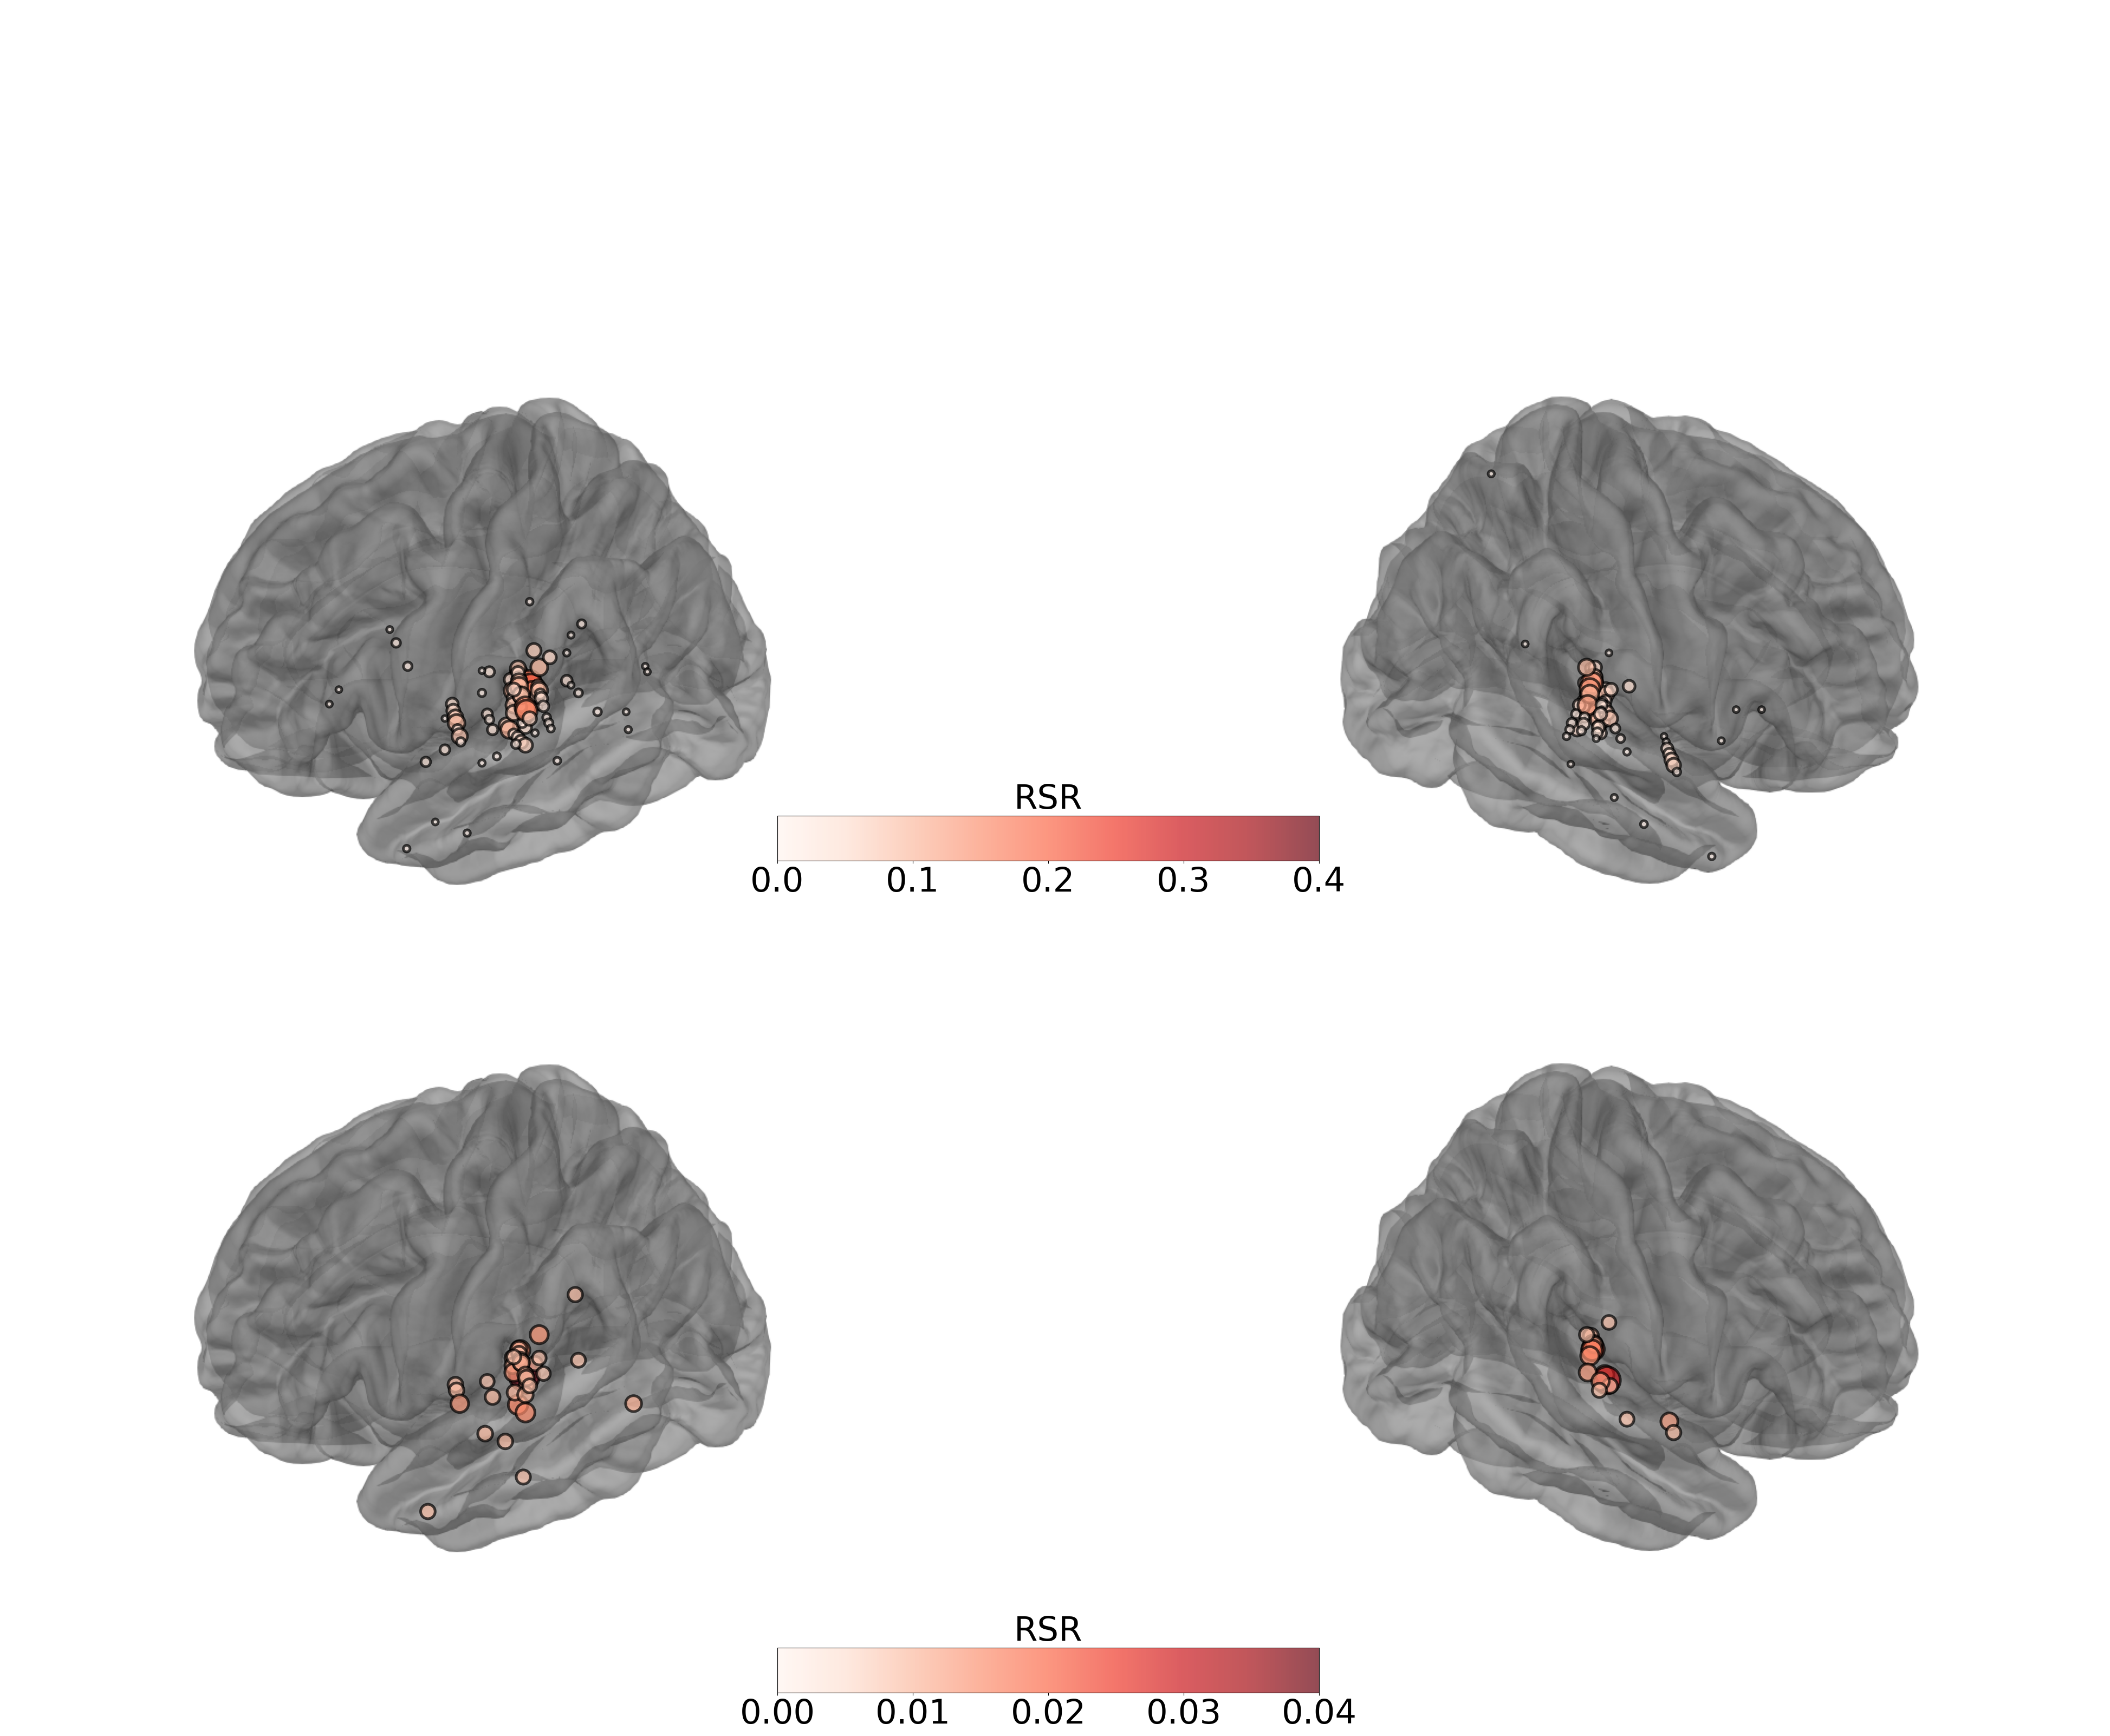

In [127]:
#Plot in the brain
for i in ('x','y','z','first','second'):
    final_tobrain[i] = final_tobrain[i].astype(float)
datas_to_plot = [final_tobrain['first'].values,final_tobrain['second'].values]
ch_names = final_tobrain['normative_name'].values
loc = final_tobrain[['x','y','z']].values
# Declare montage
ch_pos = dict(zip(ch_names, loc))
montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame='head')
info_ = mne.create_info(list(ch_names), 1000., ch_types='seeg').set_montage(montage)


mne.viz.set_3d_backend("notebook")
fig = mne.viz.create_3d_figure(size=(900, 600), bgcolor='white', scene=True)
subjects_dir = "C:\\Users\\Jeremy\\Desktop\\github_syll_phon\\data\\anatomy\\anatomy2\\"
trans =  mne.read_trans(subjects_dir + '\\fsaverage\\fsaverage-trans.fif')
surfaces = {'brain': 1}

fig =plot_alignment(info=info_,trans=trans,subject='fsaverage',subjects_dir=subjects_dir,
                 surfaces=['pial'],seeg=True, interaction='terrain',coord_frame='mri',fig=fig)

mne.viz.set_3d_view(fig,azimuth=-180, elevation=-70,distance = 0.37)
xy, im = snapshot_brain_montage(fig, montage)
xy_pts1 = np.vstack([xy[ch] for ch in info_['ch_names']])

mne.viz.set_3d_view(fig,azimuth=180, elevation=70,distance = 0.37)
xy,im2 = snapshot_brain_montage(fig, montage)
xy_pts2 = np.vstack([xy[ch] for ch in info_['ch_names']])

images = [im2,im,im2,im]

stats_tresh= [0.0112,0.0112, 0.0082,0.0082] # obtained from permutation
idxs = [0,0,1,1]
nbrs = [5000,5000,40000,40000]
vmaxs = [0.4,0.4,0.04,0.04]
fig2, axs = plt.subplots(2,2,figsize=(50, 32))
allms =[]
for i,(ax,image,idx,nb,thresh) in enumerate(zip(axs.ravel(),images,idxs,nbrs,stats_tresh)):
    
    
    vmin=0; vmax=vmaxs[i]

    if (i % 2) == 0:
        ax.imshow(image, aspect='auto') 
        mask = loc[:, 0] < 0 # Data for electrodes in left hemisphere are set to np.nan
        sizes = datas_to_plot[idx][mask]
        sizes[sizes<thresh] = 0.0 
        sizes=sizes*nb
        m = ax.scatter(*xy_pts2[mask].T, c=datas_to_plot[idx][mask], s=sizes, cmap="Reds", linewidths=3.6, edgecolors='k', alpha=.7, vmin=vmin, vmax=vmax) 
    else:
        ax.imshow(image, aspect='auto')
        mask = loc[:, 0] >0 # Data for electrodes in left hemisphere are set to np.nan
        sizes = datas_to_plot[idx][mask] 
        sizes[sizes<thresh] = 0.0
        sizes=sizes*nb

        m = ax.scatter(*xy_pts1[mask].T, c=datas_to_plot[idx][mask], s = sizes,cmap="Reds", linewidths=3.6, edgecolors='k', alpha=.7, vmin=vmin, vmax=vmax) 
        allms.append(m)
    ax.set_axis_off()
    

cax1 = fig2.add_axes([0.41, 0.53, 0.2, 0.55])
cax1.set_axis_off()
cbar1 = plt.colorbar(allms[0], ax=cax1, orientation='horizontal',aspect=12, pad=0)
cbar1.ax.tick_params(labelsize=45)
cbar1.ax.set_title('RSR',fontsize=45);
    
    
    
    
# Plot colorbar
cax3 = fig2.add_axes([0.41, 0.05, 0.2, 0.55])
cax3.set_axis_off()
cbar3 = plt.colorbar(m, ax=cax3, orientation='horizontal',aspect=12, pad=0)
cbar3.ax.tick_params(labelsize=45)
cbar3.ax.set_title('RSR',fontsize=45);
plt.subplots_adjust(hspace=0)
#fig2.savefig( "fig3F.png",  dpi=300, format=None, metadata=None,facecolor='white', edgecolor='white' , bbox_inches='tight')

In [128]:
firspek = SF.loc[(SF['RSR_lowFreq']>0.0112)].index.values
secspek = SF.loc[(SF['RSR_highFreq']>0.0082)].index.values
inter =np.intersect1d(firspek,secspek)

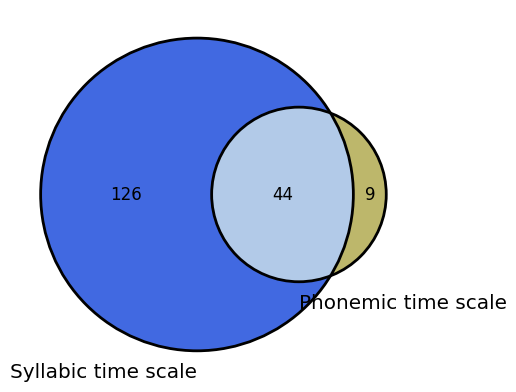

In [129]:
fig, ax = plt.subplots(1,1)
matplotlib.rcParams.update({'font.size': 12})
c = venn2(subsets = (len(firspek)-len(inter), len(secspek)-len(inter), len(inter)),
      set_labels = ('Syllabic time scale', 
                    'Phonemic time scale'),
      set_colors=('royalblue','darkkhaki'),alpha=1,ax=ax)
# add outline
venn2_circles(subsets=(len(firspek)-len(inter), len(secspek)-len(inter), len(inter)),ax=ax) 
plt.show();